# Tutorial 6

In this tutorial, we consider the study and analysis of the eigenvalue problem associated to the following anisotropic diffusion operator
$$
- \nabla \cdot \mathbf{b} \otimes \mathbf{b} \nabla \phi = \omega^2 \phi
$$
where $\mathbf{b} = (\iota, 1)$ is the normalized vector of the magnetic field.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

from vale import construct_model
import numpy as np
import os
import clapp.common.utils      as clapp_utils

# ... initializing Clapp
clapp_utils.initialize()
# ...

# ...
def construct_pde(filename, mapping, discretization):
    # ... clean input directory. needed for Fortran
    cmd = "rm -rf input"
    os.system(cmd)
    # ...

    # ... creates discretization parameters
    from clapp.disco.parameters.bspline import BSpline

    bspline_params = BSpline(discretization["n_elements"], \
                             discretization["degrees"], \
                             bc_min=[1,1], \
                             bc_max=[1,1])
    # ...

    # ... create a context from discretization
    from clapp.fema.context        import Context

    context = Context(dirname="input", \
                      discretization_params=bspline_params)
    # ...

    # ...
    pde = construct_model(filename, backend="clapp", \
                          context=context, mapping=mapping)
    # ...
    
    # ... clean input directory
    cmd = "rm -rf input"
    os.system(cmd)
    # ...
    
    return pde
# ...

We use **CAID** to create the geometry, then convert it to the *mapping* object from *CLAPP*

In [13]:
# ... creates a unit line geometry using CAID
from caid.cad_geometry import square
geometry = square()
# ...
    
# ...
from clapp.spl.mapping import Mapping
mapping = Mapping(geometry=geometry)
# ...

We specify the discretization, by giving the number of elements and spline degrees in every direction

In [14]:
# ... define a discretization
discretization = {"n_elements": [64,64], "degrees": [3,3]}
# ...

The following flag allows to assemble the involved matrices

In [15]:
with_matrix = False

In [16]:
pde = construct_pde(filename="../../glt/tests/2d/inputs/anisotropic_diffusion_2.vl", 
                    mapping=mapping, 
                    discretization=discretization)

form_a = pde["a"]
b1     = pde["b1"]
b2     = pde["b2"]

b1.set("1.1659397624413860850012270020670")
b2.set("1.0")

# ... compute the glt symbol and evaluate it
from glt.expression import glt_symbol_from_weak_formulation

expr_a = glt_symbol_from_weak_formulation(form_a, 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization)
# ...

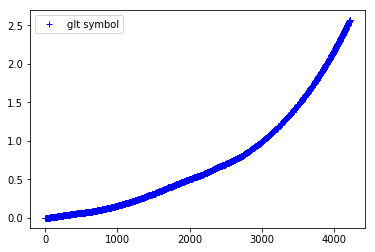

In [17]:
from glt.expression import glt_approximate_eigenvalues
t = glt_approximate_eigenvalues(expr_a, discretization)
t.sort()
plt.plot(t, "+b", label="glt symbol")       
# ...
if with_matrix:
    # ... assembling the linear system
    form_a.assembler.assemble()
    # ...
    
    # ...
    from scipy.linalg import eig
    M = form_a.matrix.get().todense()
    w, v = eig(M)
    wr = w.real
    wr.sort()
    plt.plot(wr, "xr", label="eigenvalues")
    # ...
# ...
plt.legend(loc=2);

In [18]:
pde2 = construct_pde(filename="../../glt/tests/2d/inputs/mass.vl", 
                    mapping=mapping, 
                    discretization=discretization)

form_c = pde2["c"]

# ... compute the glt symbol and evaluate it
from glt.expression import glt_symbol_from_weak_formulation

expr_c = glt_symbol_from_weak_formulation(form_c, 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization)
# ...

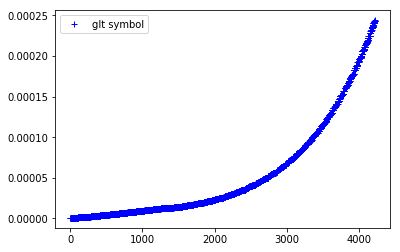

In [19]:
from glt.expression import glt_approximate_eigenvalues
t = glt_approximate_eigenvalues(expr_c, discretization)
t.sort()
plt.plot(t, "+b", label="glt symbol")       
# ...

if with_matrix:
    # ... assembling the linear system
    form_c.assembler.assemble()
    # ...
        
    # ...
    from scipy.linalg import eig
    M = form_c.matrix.get().todense()
    w, v = eig(M)
    wr = w.real
    wr.sort()
    plt.plot(wr, "xr", label="eigenvalues")
    # ...
# ...
plt.legend(loc=2);

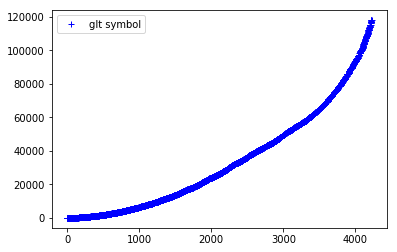

In [20]:
from glt.expression import glt_approximate_eigenvalues
t_a = glt_approximate_eigenvalues(expr_a, discretization)
t_c = glt_approximate_eigenvalues(expr_c, discretization)
t = t_a / t_c

t.sort()
plt.plot(t, "+b", label="glt symbol")       
# ...

if with_matrix:
    # ...
    from scipy.linalg import eig
    A = form_a.matrix.get().todense()
    C = form_c.matrix.get().todense()
    w, v = eig(A, C)
    wr = w.real
    wr.sort()
    plt.plot(wr, "xr", label="eigenvalues")
    # ...
# ...
plt.legend(loc=2);

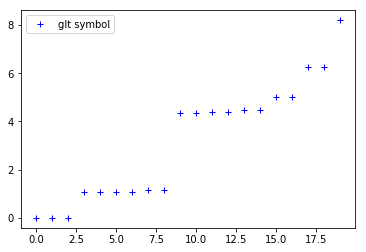

In [21]:
plt.plot(t[:20], "+b", label="glt symbol")

if with_matrix:
    plt.plot(wr[:20], "xr", label="eigenvalues")
plt.legend(loc=2);

In [22]:
print t[:10]

[ -5.69998292e-13   1.42589272e-02   1.42589272e-02   1.07646138e+00
   1.07646138e+00   1.08707790e+00   1.08707790e+00   1.14835674e+00
   1.14835674e+00   4.34831231e+00]


Since the glt symbols can be evaluated, let's plot their ratio 

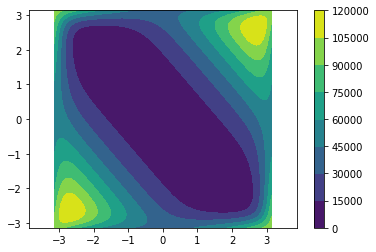

In [23]:
# ... lambdify the glt symbol
from glt.expression import glt_lambdify

f_a = glt_lambdify(expr_a, dim=2)
f_c = glt_lambdify(expr_c, dim=2)
# ...

# ... compute the symbol f_a / f_c
nx = 100 ; ny = 100
t1 = np.linspace(-np.pi,np.pi, nx)
t2 = np.linspace(-np.pi,np.pi, ny)

u = np.linspace(0.,1.,nx)
v = np.linspace(0.,1.,ny)

x = mapping.evaluate(u,v)[0,:,:]
y = mapping.evaluate(u,v)[1,:,:]

t1, t2 = np.meshgrid(t1, t2)

f = f_a(x,y,t1,t2)/f_c(x,y,t1,t2);
# ...

# ... plot
plt.contourf(t1, t2, f)
plt.axis("equal")
plt.colorbar();
# ...

In [30]:
b_1 = 1.1659397624413860850012270020670 ; b_2 = 1.0
N = discretization["n_elements"][0] ; M = discretization["n_elements"][1]
n = range(-N/2, N/2+1) 
m = range(-M/2, M/2+1)
n,m = np.meshgrid(n,m)
e = (b_1*n + b_2*m)**2 / (4 * np.pi**2)

In [33]:
e = e.ravel()
e.sort()
print(e[:10])
print e.shape

[  0.00000000e+00   4.81833677e-07   4.81833677e-07   1.92733471e-06
   1.92733471e-06   4.33650309e-06   4.33650309e-06   7.70933882e-06
   7.70933882e-06   5.58545339e-04]
(4225,)


In [45]:
# ... Finalizing Clapp
clapp_utils.finalize()
# ...